In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [8]:
energies = pd.read_csv('../20220512_icsd_and_battery/predicted_energies.csv.gz', index_col=0)
volumes = pd.read_csv('../20220512_icsd_and_battery_vol/predicted_volumes.csv.gz', index_col=0)
combined = pd.read_csv('../20220512_icsd_and_battery_combined/predicted_volumes.csv.gz', index_col=0)

In [9]:
energies['energy_err'] = (energies['energyperatom'] - energies['energy_predicted']).abs()
energies.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.037,0.027,0.049
test_composition,0.060,0.050,0.070
valid,0.035,0.027,0.050


In [10]:
volumes['vol_err'] = (volumes['volperatom'] - volumes['volume_predicted']).abs()
volumes.groupby(['set', 'type']).vol_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.294,0.484,0.305
test_composition,0.822,0.587,0.435
valid,0.309,0.477,0.310


In [11]:
combined['vol_err'] = (combined['volperatom'] - combined['volume_predicted']).abs()
combined['energy_err'] = (combined['energyperatom'] - combined['energy_predicted']).abs()
combined.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.046,0.028,0.045
test_composition,0.071,0.057,0.073
valid,0.044,0.029,0.045


In [52]:
combined.groupby(['set', 'type']).vol_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.322,0.517,0.357
test_composition,0.834,1.487,0.925
valid,0.328,0.534,0.356


In [12]:
energies = pd.read_csv('../20220603_icsd_and_battery/predicted_energies.csv.gz', index_col=0)
combined = pd.read_csv('../20220603_icsd_and_battery_combined/predicted_volumes.csv.gz', index_col=0)

In [24]:
energies.shape

(145877, 11)

In [13]:
energies['energy_err'] = (energies['energyperatom'] - energies['energy_predicted']).abs()
energies.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.040,0.026,0.041
test_composition,0.058,0.041,0.078
valid,0.039,0.026,0.042


In [14]:
combined['vol_err'] = (combined['volperatom'] - combined['volume_predicted']).abs()
combined['energy_err'] = (combined['energyperatom'] - combined['energy_predicted']).abs()
combined.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.037,0.026,0.047
test_composition,0.051,0.044,0.089
valid,0.035,0.026,0.048


In [16]:
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

In [17]:
volumes.type = volumes.type.astype('category')
energies.type = energies.type.astype('category')

In [20]:
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

# artist = dsshow(volumes,
#        ds.Point('volume_predicted', 'volperatom'),
#        ds.count_cat('type'),       
#        cmap='Blues', norm='eq_hist', aspect='equal',
#        x_range=(0, 70), y_range=(0, 70), ax=ax)

# ax.set_xlabel('vol/atom, ML')
# ax.set_ylabel('vol/atom, DFT')
# ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
# sns.despine()

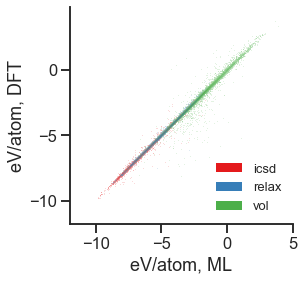

In [23]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(energies,
       ds.Point('energy_predicted', 'energyperatom'),
       ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(-12, 5), y_range=(-12, 5), ax=ax)

ax.set_xlabel('eV/atom, ML')
ax.set_ylabel('eV/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

In [44]:
import math
import os
import shutil
from collections import Counter
from pathlib import Path

import nfp
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from nfp.layers import RBFExpansion
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tqdm.auto import tqdm

import sys
sys.path.append('..')
from preprocess import preprocessor

tqdm.pandas()

inputs_dir = Path("/projects/rlmolecule/pstjohn/crystal_inputs/")
data = pd.read_pickle(Path(inputs_dir, "20220603_outliers_removed.p"))
max_atomic_num = 84

composition_set = data.composition.isin(
    pd.Series(data.composition.unique()).sample(100, random_state=1)
)
test_composition = data[composition_set]
train_composition = data[~composition_set]

train, valid = train_test_split(
    train_composition,
    test_size=3000,
    random_state=1,
    stratify=train_composition["type"],
)

valid, test = train_test_split(
    valid,
    test_size=0.5,
    random_state=2,
    stratify=valid["type"],
)

In [45]:
data["set"] = "train"
data.loc[data.index.isin(valid.index), "set"] = "valid"
data.loc[data.index.isin(test.index), "set"] = "test"
data.loc[data.index.isin(test_composition.index), "set"] = "test_composition"

In [46]:
data.set.value_counts()

train               141385
valid                 1500
test                  1500
test_composition      1492
Name: set, dtype: int64